<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting the Density Estimator

In [1]:
## todo add forked repo as origin or upstream
## check paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#! pip install --user -e /global/u2/v/vboehm/codes/SIG_GIS/

In [3]:
import sys

In [4]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')

In [5]:
from sig_gis import *

In [6]:
from sig_gis.GIS import *

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_outliers   = '/global/cscratch1/sd/vboehm/SDSSOutlier'

root_prepped    = os.path.join(root_data,'sdss/prepped')

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'

seed            = 8720

latent_dim      = 10

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)


alpha         = (0.8,0.8)

maxiter       = 2000

label_3       = label_2+"alpha%d_maxiter%d"%(int(alpha[0]*10),maxiter)



encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)
decoded_train, decoded_valid, decoded_test, mean = np.load(os.path.join(root_decoded,'decoded_%s.npy'%label_2), allow_pickle=True)



#seed = 8365

In [9]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')

In [10]:
encoded_train = torch.tensor(encoded_train).to(device)
encoded_valid = torch.tensor(encoded_valid).to(device)
encoded_test = torch.tensor(encoded_test).to(device)

In [11]:
print(os.path.join(root_models,'GIS_%s'%label_3))

/global/cscratch1/sd/vboehm/Models/SDSS_AE/GIS_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_divalpha8_maxiter2000


In [12]:
try:
    model =  torch.load(os.path.join(root_models,'GIS_%s_%d'%(label_3,seed)))
except:
    print('model not found')

In [13]:
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))

In [14]:
test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

In [15]:
encoded_valid.device

device(type='cuda', index=0)

In [16]:
logps_valid   = model.evaluate_density(encoded_valid).cpu()
indices_valid = np.argsort(logps_valid)

logps_test   = model.evaluate_density(encoded_test).cpu()
indices_test = np.argsort(logps_test)

logps_train   = model.evaluate_density(encoded_train).cpu()
indices_train = np.argsort(logps_train)

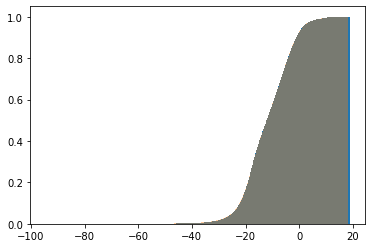

In [17]:
_ = plt.hist(logps_valid.numpy(),bins=1000,density=True,cumulative=True)
_ = plt.hist(logps_test.numpy(),bins=1000,alpha=0.4,density=True,cumulative=True)

Text(0.5, 0, 'logps')

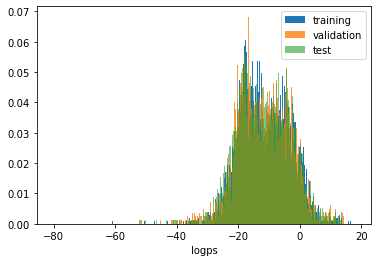

In [18]:
_ = plt.hist(logps_train.numpy()[0:10000],bins=1000,density=True,cumulative=False, label='training')
_ = plt.hist(logps_valid.numpy()[0:10000],bins=1000,alpha=0.8,density=True,cumulative=False, label='validation')
_ = plt.hist(logps_test.numpy()[0:10000],bins=1000,alpha=0.6,density=True,cumulative=False, label='test')

plt.legend()
plt.xlabel('logps')

In [19]:
np.savez(os.path.join(root_outliers,'valid_test_train_logps.npy'),logps_valid,logps_test, logps_train)

In [20]:
valid_data['arr_3'][0],valid_data['arr_4'][0],valid_data['arr_5'][0],valid_data['arr_6'][0],valid_data['arr_8'][0],valid_data['arr_9'][0],valid_data['arr_10'][0]

(0.11503215, 133.34784, 39.797764, b'2.0', b'52669.0', b'1198.0', b'427.0')

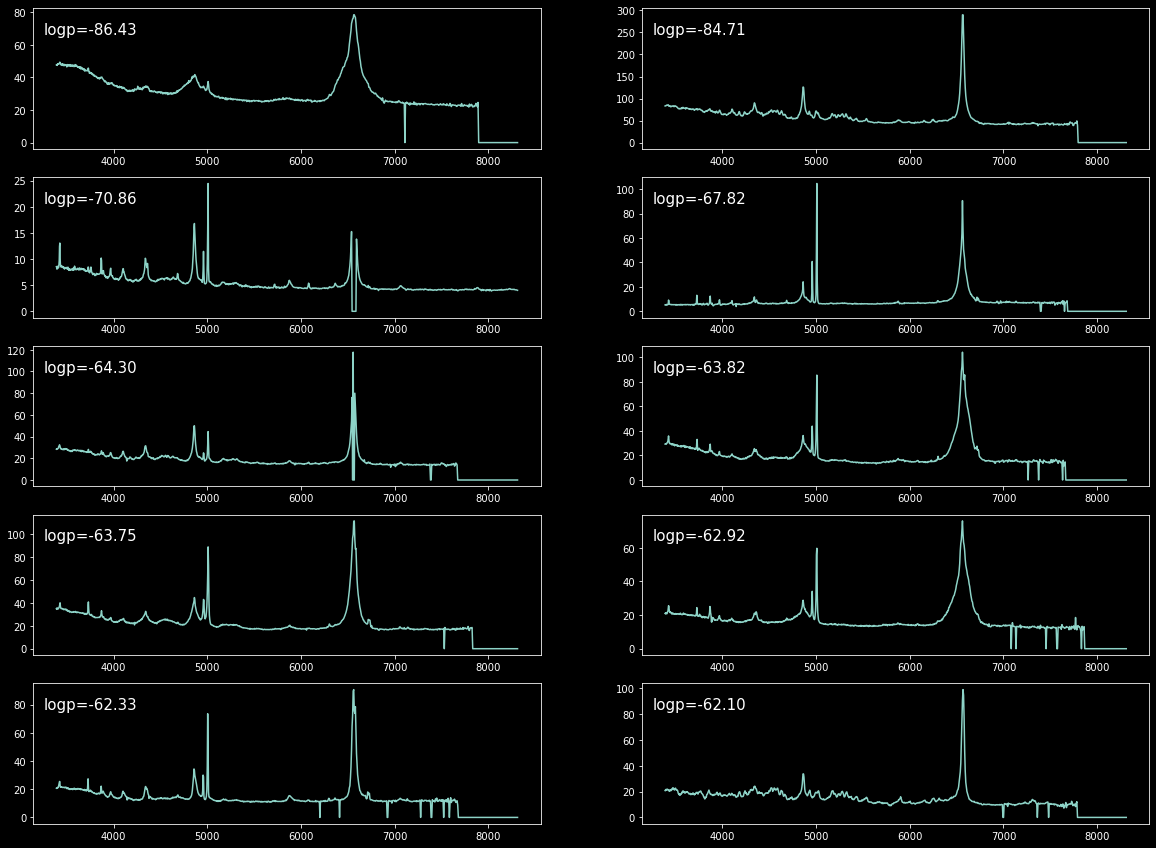

In [21]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,2, figsize=(20,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_valid[0:10]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii])*np.squeeze(valid_data['arr_1'])[ii], )
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii])*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]), color='red')
                #ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.05, 0.90, r'coords=(%d, %d, %d)'%(int(float(valid_data['arr_8'][ii])),int(float(valid_data['arr_9'][ii])),int(float(valid_data['arr_10'][ii]))), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.80, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][ii],valid_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.70, r'z=%.3f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.90, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [ ]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,2, figsize=(20,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_valid[-10::]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii])*np.squeeze(valid_data['arr_1'])[ii], )
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii])*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]), color='red')
                #ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.05, 0.90, r'coords=(%d, %d, %d)'%(int(float(valid_data['arr_8'][ii])),int(float(valid_data['arr_9'][ii])),int(float(valid_data['arr_10'][ii]))), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.80, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][ii],valid_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.70, r'z=%.3f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.90, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

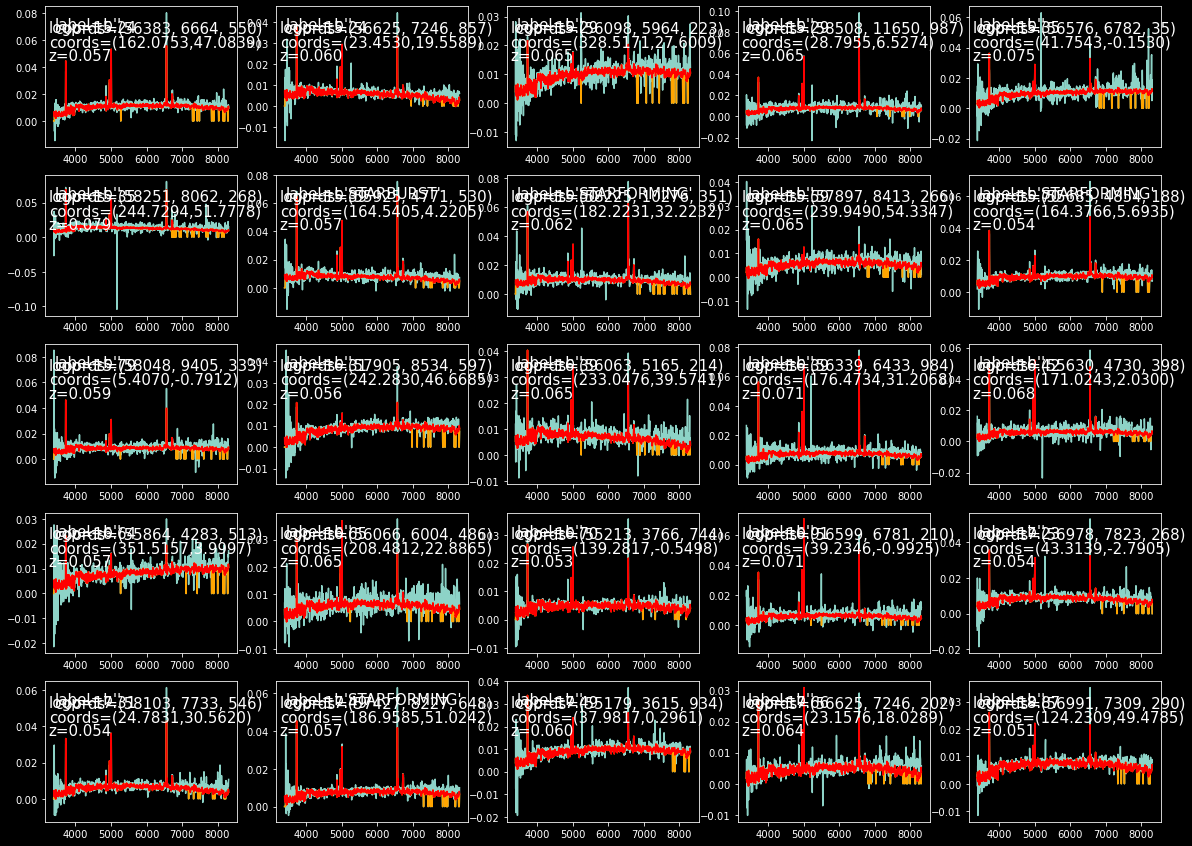

In [23]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(20,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_valid[-25::]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii])*np.squeeze(valid_data['arr_1'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii])*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]), color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.90, r'coords=(%d, %d, %d)'%(int(float(valid_data['arr_8'][ii])),int(float(valid_data['arr_9'][ii])),int(float(valid_data['arr_10'][ii]))), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.80, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][ii],valid_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.70, r'z=%.3f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.90, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

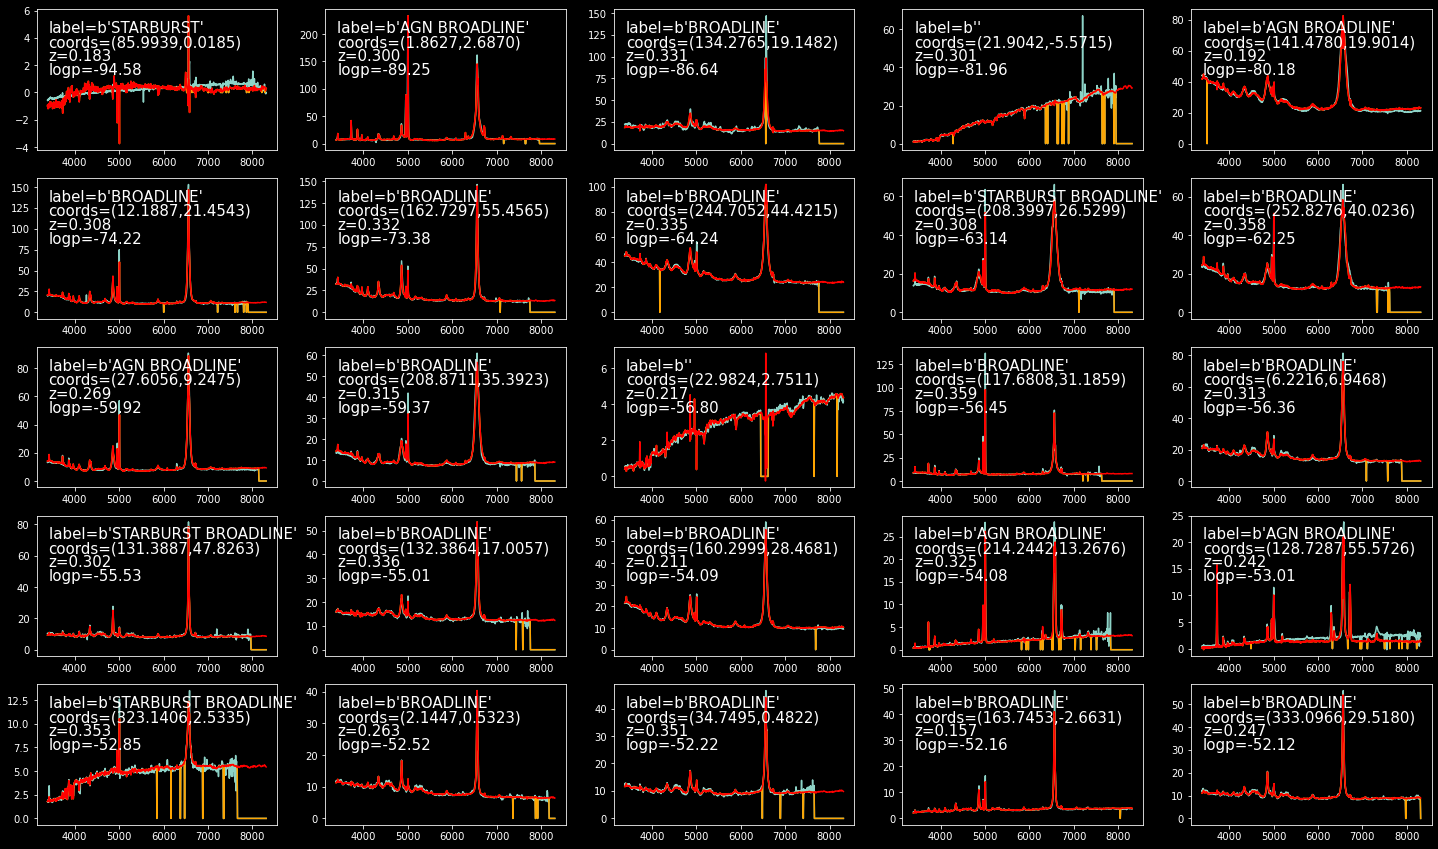

In [24]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_test[0:25]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(test_data['arr_0'])[ii])*np.squeeze(test_data['arr_1'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_test)[ii])*np.squeeze(test_data['arr_1'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_test)[ii]), color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%test_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(test_data['arr_4'][ii],test_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%test_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_test[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

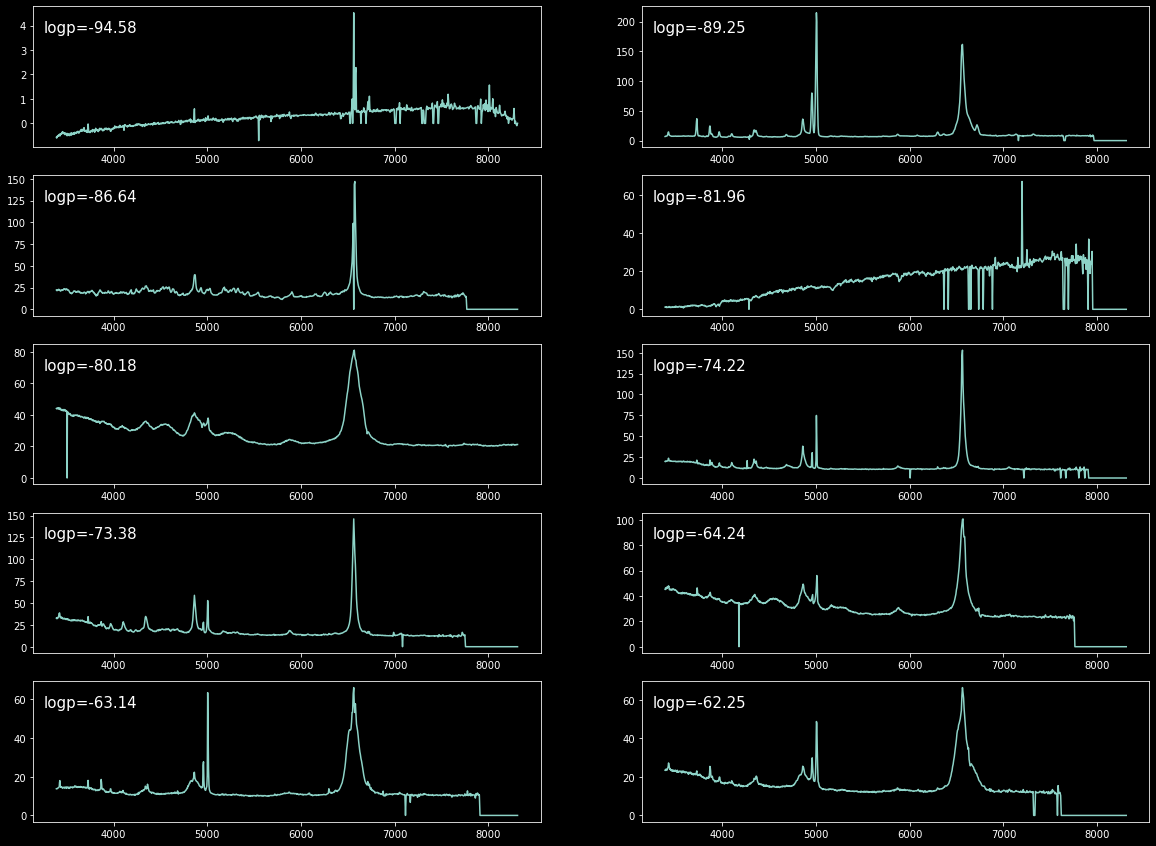

In [25]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,2, figsize=(20,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices_test[0:10]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(test_data['arr_0'])[ii])*np.squeeze(test_data['arr_1'])[ii], )
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii])*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]), color='red')
                #ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.05, 0.90, r'coords=(%d, %d, %d)'%(int(float(valid_data['arr_8'][ii])),int(float(valid_data['arr_9'][ii])),int(float(valid_data['arr_10'][ii]))), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.80, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][ii],valid_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.70, r'z=%.3f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.90, r'logp=%.2f'%logps_test[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [26]:
ood_valid_fibers = valid_data['arr_10'][indices_valid]
ood_valid_plate = valid_data['arr_9'][indices_valid]
ood_valid_MJD = valid_data['arr_8'][indices_valid]
ood_valid_coord1 = valid_data['arr_4'][indices_valid]
ood_valid_coord2 = valid_data['arr_5'][indices_valid]
ood_valid_params = valid_data['arr_3'][indices_valid]

In [27]:
np.savez(os.path.join(root_outliers,'MJD_plate_fiber_top1000outliers_valid.npy'), ood_valid_MJD[:1000], ood_valid_plate[:1000], ood_valid_fibers[:1000])

In [28]:
ood_test_fibers = test_data['arr_10'][indices_test]
ood_test_plate = test_data['arr_9'][indices_test]
ood_test_MJD = test_data['arr_8'][indices_test]
ood_test_coord1 = test_data['arr_4'][indices_test]
ood_test_coord2 = test_data['arr_5'][indices_test]
ood_test_params = test_data['arr_3'][indices_test]

In [29]:
np.savez(os.path.join(root_outliers,'MJD_plate_fiber_top1000outliers_test.npy'), ood_test_MJD[:1000], ood_test_plate[:1000], ood_test_fibers[:1000])

In [39]:
with open('ood_valid_lowest_1000.txt', 'w') as f:
    for ii in range(1000):
        f.write('%d,%d,%d'%(int(float(ood_valid_plate[ii])), int(float(ood_valid_MJD[ii])), int(float(ood_valid_fibers[ii]))+1))
        f.write('\n')
f.close()

In [30]:
with open('ood_test_lowest_1000.txt', 'w') as f:
    for ii in range(1000):
        f.write('%d,%d,%d'%(int(float(ood_test_plate[ii])), int(float(ood_test_MJD[ii])), int(float(ood_test_fibers[ii]))+1))
        f.write('\n')
f.close()

In [30]:
import pandas as pd

In [31]:
df = pd.read_csv(os.path.join('./','optical_search_1000validoutlier.csv'))

In [32]:
df

,#plate,mjd,fiberid,run2d,specobj_id,ra,dec,sn_median_r,z,zerr,zwarning,class,subclass
0,281,51614,563,'26','316532657162840064','11:30:47.52','+01:02:03.02',0.29,0.228554,0.000228,5,'QSO',''
1,341,51690,426,'26','384048994575214592','13:19:33.35','-01:36:00.31',23.11,0.142406,0.000031,0,'GALAXY',''
2,413,51821,210,'26','465054416437798912','03:17:58.04','-01:09:11.69',11.83,0.138530,0.000055,0,'GALAXY',''
3,419,51812,422,'26','471868089844131840','00:42:55.61','+15:08:02.68',29.74,0.079772,0.000018,0,'GALAXY',''
4,419,51879,423,'26','471868365846112256','00:43:02.53','+15:19:38.07',20.55,0.077968,0.000024,0,'GALAXY',''
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,11401,58491,558,'v5_13_0','-5610205711468048384','13:17:05.97','+30:54:02.92',1.61,2.547930,0.000420,0,'QSO',''
995,11554,58456,991,'v5_13_0','-5437824004174622720','23:39:36.10','+11:10:34.51',23.45,0.623715,0.000069,0,'QSO','BROADLINE'
996,11649,58514,281,'v5_13_0','-5331058675365425152','15:10:31.38','+38:47:47.52',2.25,0.553712,0.000173,0,'GALAXY',''
997,11649,58514,479,'v5_13_0','-5331004249539850240','15:05:28.24','+40:04:36.07',1.91,1.821370,0.001206,0,'QSO','BROADLINE'


In [33]:
array= np.vstack([ood_valid_plate.astype(float).astype(int)[:1000], ood_valid_MJD.astype(float).astype(int)[:1000], ood_valid_fibers.astype(float).astype(int)[:1000]+1, ood_valid_params[:1000], ood_valid_coord1[:1000], ood_valid_coord2[:1000]])

In [34]:
df_2 = pd.DataFrame(array.T,columns=['#plate','mjd','fiberid','z','ra', 'dec'])

In [35]:
df_2

,#plate,mjd,fiberid,z,ra,dec
0,8869.0,57481.0,47.0,0.309608,194.538803,35.328609
1,10449.0,58137.0,659.0,0.328802,151.010864,28.926487
2,8428.0,57837.0,473.0,0.174773,210.209274,53.406818
3,8061.0,58253.0,247.0,0.344732,247.740204,52.521076
4,8424.0,58248.0,316.0,0.347341,237.736526,58.935078
...,...,...,...,...,...,...
995,1330.0,52822.0,392.0,0.110975,227.013214,48.957817
996,10914.0,58257.0,341.0,0.271530,248.707642,32.070190
997,2610.0,54476.0,533.0,0.121928,184.439713,20.737513
998,4384.0,56105.0,225.0,0.312768,322.428436,-2.881597


In [36]:
df_overlap=df.merge(df_2,how='inner',on=['#plate','mjd','fiberid'])

In [38]:
df_overlap

,#plate,mjd,fiberid,run2d,specobj_id,ra_x,dec_x,sn_median_r,z_x,zerr,zwarning,class,subclass,z_y,ra_y,dec_y
0,281,51614,563,'26','316532657162840064','11:30:47.52','+01:02:03.02',0.29,0.228554,0.000228,5,'QSO','',0.132577,172.589203,0.973066
1,341,51690,426,'26','384048994575214592','13:19:33.35','-01:36:00.31',23.11,0.142406,0.000031,0,'GALAXY','',0.121111,200.676987,-2.422796
2,413,51821,210,'26','465054416437798912','03:17:58.04','-01:09:11.69',11.83,0.138530,0.000055,0,'GALAXY','',0.117274,49.470459,-0.904867
3,419,51812,422,'26','471868089844131840','00:42:55.61','+15:08:02.68',29.74,0.079772,0.000018,0,'GALAXY','',0.117565,10.719017,15.546323
4,419,51879,423,'26','471868365846112256','00:43:02.53','+15:19:38.07',20.55,0.077968,0.000024,0,'GALAXY','',0.117537,10.719017,15.546323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,11401,58491,558,'v5_13_0','-5610205711468048384','13:17:05.97','+30:54:02.92',1.61,2.547930,0.000420,0,'QSO','',0.285297,199.144363,30.915642
995,11554,58456,991,'v5_13_0','-5437824004174622720','23:39:36.10','+11:10:34.51',23.45,0.623715,0.000069,0,'QSO','BROADLINE',0.282495,354.733459,11.222998
996,11649,58514,281,'v5_13_0','-5331058675365425152','15:10:31.38','+38:47:47.52',2.25,0.553712,0.000173,0,'GALAXY','',0.251546,227.511734,40.047775
997,11649,58514,479,'v5_13_0','-5331004249539850240','15:05:28.24','+40:04:36.07',1.91,1.821370,0.001206,0,'QSO','BROADLINE',0.352357,226.325867,40.043076


In [39]:
df_3 = df_2.merge(df,indicator = True, how='left',on=['#plate','mjd','fiberid']).loc[lambda x : x['_merge']!='both']

In [40]:
df_3= df_3.drop(columns=['run2d','specobj_id','ra_y','dec_y','sn_median_r','z_y','zerr', 'zwarning', 'class', 'subclass', '_merge'])

In [41]:
df_3 = df_3.rename(columns={'z_x':'z', 'ra_x':'ra', 'dec_x':'dec'})

In [45]:
df_3
### searching ra, dec, i fnd an object with same redshift but plate number +1:
#5106, 55833, 1000, 02:05:11.86, 18:11:20.52, 0.302001, 0.000015
df_3

,#plate,mjd,fiberid,z,ra,dec
373,5106.0,55833.0,1001.0,0.302001,31.299437,18.189032


In [46]:
df_3.to_csv(os.path.join('./outlier_data','unmatched_valid_outliers.csv'))

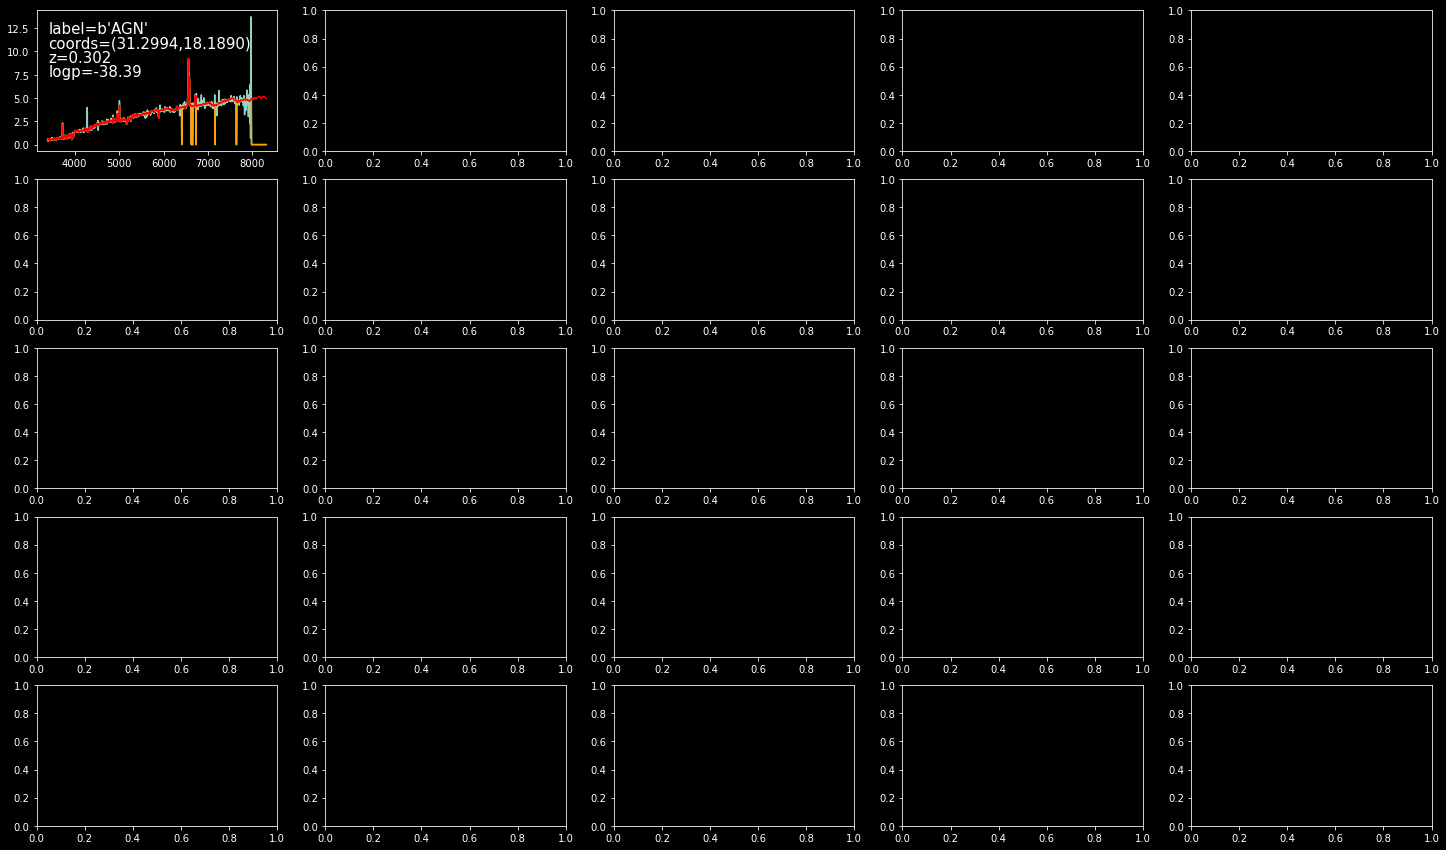

In [47]:
##change to show correct spectra

style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(df_3.index[0:25]):
                print
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[indices_valid][ii])*np.squeeze(valid_data['arr_1'][indices_valid])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[indices_valid][ii])*np.squeeze(valid_data['arr_1'][indices_valid])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid[indices_valid])[ii]), color='red')
                ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][indices_valid][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][indices_valid][ii],valid_data['arr_5'][indices_valid][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.72, r'z=%.3f'%valid_data['arr_3'][indices_valid][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.62, r'logp=%.2f'%logps_valid[indices_valid][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

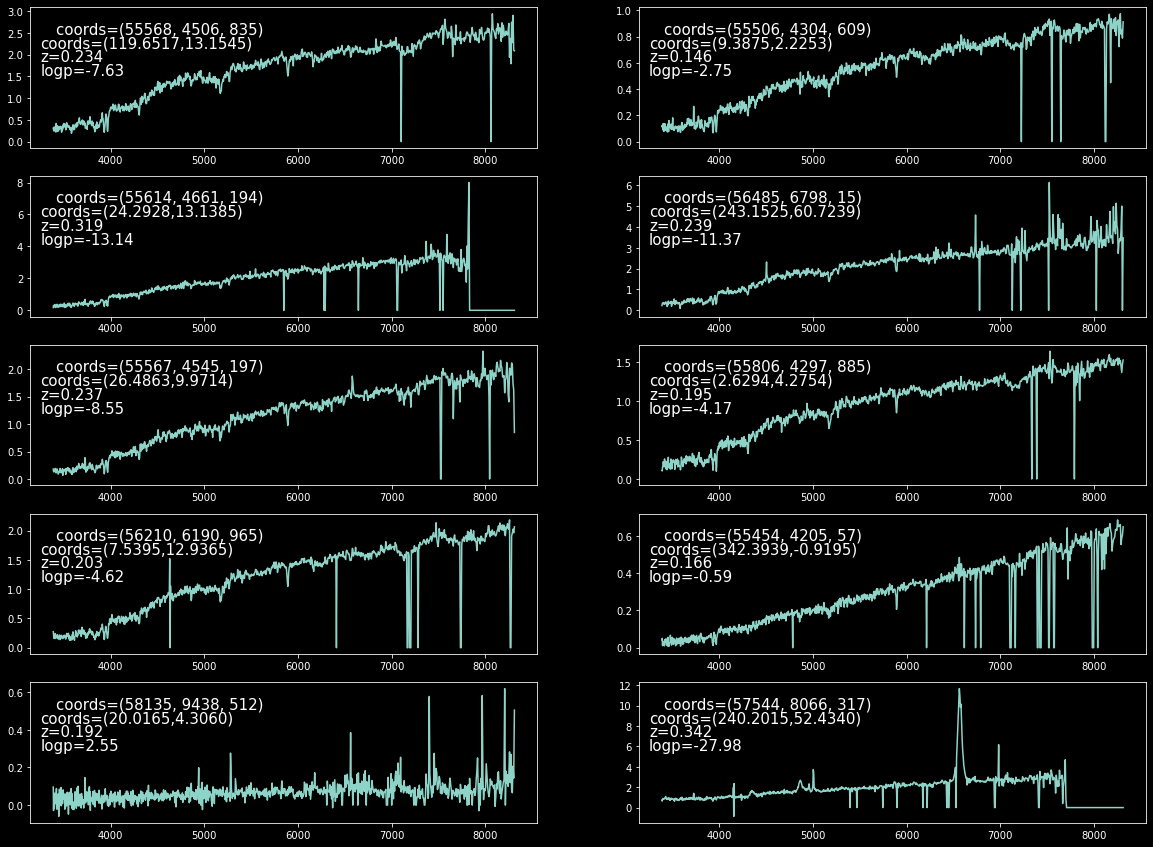

In [43]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,2, figsize=(20,15))
            ax = ax.flatten()
            for nn, ii in enumerate(df_3.index[0:10]):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid_data['arr_0'])[ii])*np.squeeze(valid_data['arr_1'])[ii], )
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii])*np.squeeze(valid_data['arr_1'])[ii], color='orange')
                #ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid)[ii]), color='red')
                #ax[nn].text(0.05, 0.92, r'label=%s'%valid_data['arr_7'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.05, 0.90, r'coords=(%d, %d, %d)'%(int(float(valid_data['arr_8'][ii])),int(float(valid_data['arr_9'][ii])),int(float(valid_data['arr_10'][ii]))), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.80, r'coords=(%.4f,%.4f)'%(valid_data['arr_4'][ii],valid_data['arr_5'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                #ax[nn].text(0.02, 0.70, r'z=%.3f'%valid_data['arr_3'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.02, 0.90, r'logp=%.2f'%logps_valid[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()

In [44]:
### derivative 

In [45]:
"""
def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
"""

'\ndef closure():\n        optimizer.zero_grad()\n        output = model(input)\n        loss = loss_fn(output, target)\n        loss.backward()\n        return loss\n'

In [46]:

 # the desired network response

num_steps = 20  # how many optim steps to take
updates   = []
logps     = []
for nn in range(1):
    print(nn)
    model.requires_grad_(False)
    x = torch.nn.Parameter(encoded_valid[indices_valid][nn], requires_grad=True)
    optim = torch.optim.LBFGS([x],lr=1e-4, history_size=3)
    for _ in range(num_steps):
        updates.append(x.cpu().detach().numpy())
        def closure():
            optim.zero_grad()
            logp = -model.evaluate_density(x)
            logp.backward()
            return logp
        logps.append(closure().cpu().detach().numpy())
        
        optim.step(closure)
        
    
    

0


KeyboardInterrupt: 

In [ ]:
logps=np.asarray(logps)
print(logps.shape), 20*25

In [ ]:
logps

In [ ]:
updates = []
logps   = []
for nn in range(25):
    print(nn)
    encoded_valid_sorted = encoded_valid[indices_valid][nn]
    encoded_valid_sorted = encoded_valid_sorted.clone().detach().requires_grad_(True)
    current_pos          = encoded_valid_sorted
    external_grad = torch.tensor(np.ones((1)))
    logp_ = model.evaluate_density(current_pos)
    logps.append(logp_.cpu().detach().numpy())
    updates.append(current_pos.cpu().detach().numpy())
    for ii in range(10):

        logp_.backward(gradient=external_grad)

        gradients = encoded_valid_sorted.grad

        cont = True
        step      = np.ones((8), dtype=np.float32)*5
        step      = torch.tensor(step).to(device)
        while cont:

            update      = current_pos+gradients*step
            logp_update = model.evaluate_density(update)

            if logp_update.cpu()<logp_.cpu():
                step*=0.5
            #    print('repeat')
            else:
            #if len(ind) ==0:
                cont=False
            #else:
            #    step[ind]=step[ind]*0.5

        current_pos = update
        logp_       = model.evaluate_density(current_pos)
        logps.append(logp_.cpu().detach().numpy())
        updates.append(current_pos.cpu().detach().numpy())

In [ ]:
np.savez('derivative_top25_valid_adam.npy', np.asarray(-logps).reshape(25,20,1),np.asarray(updates).reshape(25,20,8))

In [ ]:
logps = np.asarray(logps).reshape(25,20,1)
for ii in range(logps.shape[1]):
    plt.plot(-logps[:,ii,:], ls='', marker='o')
plt.grid()